# Analysis of tuberculosis images

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Loading dataset

In [2]:
from dataset import get_dataset

nb_pixel = int(1e5)
x,y,file_names = get_dataset("tuberculosis")
x_pixel = x.reshape(-1,3)[np.random.randint(0,len(x),size=nb_pixel)]
print(f" nb pixel considered : {nb_pixel}")

 nb pixel considered : 100000


## 2. Finding an appropriate W

In [3]:
from color_tools import WEstimations

nb_stain = 8

W, model = WEstimations.GMM_based_estimation(x_pixel, nb_stain, verbose=1)

def transform_img(img):
    img_shape = img.shape
    img_pixeled = img.reshape(-1,3)
    classes = model.predict(img_pixeled)
    predicted_pixeled = W[classes]
    img_pred = predicted_pixeled.reshape(img_shape)
    return img_pred

Initialization 0
  Iteration 10
  Iteration 20
Initialization converged.


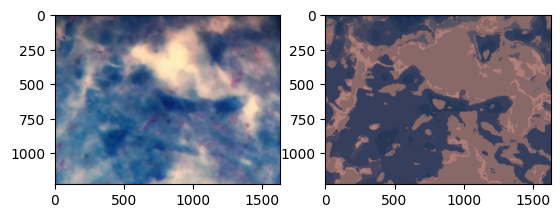

In [4]:
fix,ax = plt.subplots(1,2)
img_0 = x[0]
img_proj = np.asarray(np.rint(transform_img(img_0)), dtype=np.uint8)
ax[0].imshow(img_0)
ax[1].imshow(img_proj)
plt.show()

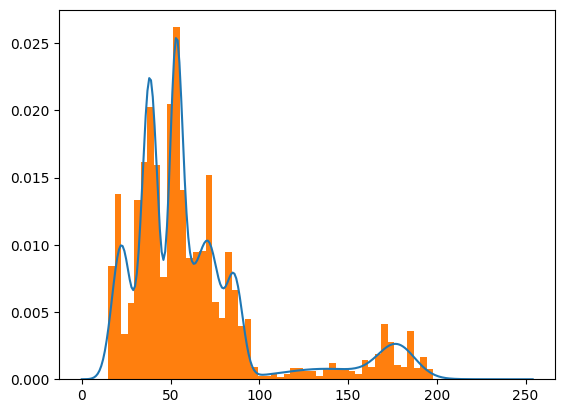

In [5]:
import scipy
def marginal_density(gmm_means, gmm_covs, gmm_probs, dim_to_keep, points):
    """
    Compute the marginal density of the GMM
    """
    density_values = np.zeros(len(points))
    
    for mean, cov, prob in zip(gmm_means, gmm_covs, gmm_probs):
        mean_marginal = mean[dim_to_keep]
        cov_marginal = cov[np.ix_(dim_to_keep, dim_to_keep)]
        
        marginal_gaussian = scipy.stats.multivariate_normal(mean=mean_marginal, cov=cov_marginal)
        
        # Compute the density for each component
        density_values += prob * marginal_gaussian.pdf(points)
    
    return density_values


density = marginal_density(model.means_, model.covariances_, model.weights_, [0], np.arange(255))
fix,ax = plt.subplots(1,1)
ax.plot(density)
ax.hist(x_pixel[:,0], bins=50, density=True)
plt.show()

## Find H

In [21]:
from color_deconstruction import PGD, GD
from color_tools import convert_to_db, convert_db_to_img
import torch

V = torch.Tensor(convert_to_db(img_0 / 255)).permute(2,0,1) # (c, h, w)
V_shape = V.shape
H0 = 1/100 * torch.Tensor(np.random.random((nb_stain, img_0.shape[0], img_0.shape[1]))) # (nb_stain, h, w)
W_torch = torch.Tensor(W).T # (c, nb_stain)

In [44]:
# Better init H0
H0 = GD(H0, V, W_torch, 100, 1e-3)

In [50]:
H = PGD(H0, V, W_torch, 100, 1e-4, 1e-2, 1e-2, 1e-5)
H_reshaped = H.view(nb_stain, -1)
pred_img = 255*convert_db_to_img((W_torch @ H_reshaped).reshape(V_shape).permute(1,2,0).detach().numpy())
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_0)
ax[1].imshow(np.asarray(np.rint(pred_img), dtype=np.uint8))

KeyboardInterrupt: 